# **Eigenvalue Problem for the Steady Stokes Flow**

The Stokes eigenvalue problem (**SEP**) is:

For a given domain $\Omega \subset \Re$ with Lipschitz boundary, in this case $\Omega = [0,1]\times[0,1]$, find $\lambda \in \Re$, the velocity $\vec{u}$ and the pressure $p$ such that

$$\begin{align*} - \nu \nabla^2\vec{u} + \nabla p &= \lambda \vec{u} \quad \text{in} \quad \Omega, 
\\\nabla \cdot \vec{u} &= 0 \quad \text{in} \quad \Omega, 
\\ \vec{u} &= 0 \quad \text{on} \quad \partial \Omega \end{align*}$$

# _**Implementación**_

### _Librerías_

In [1]:
from mpi4py import MPI # Message Passing Interface.
# Is an standar for different libraries to function properly and with high performance
import dolfinx # FeniCSx Interface
import numpy as np # Numpy, the classic

import ufl
from basix.ufl import element, mixed_element # Elements for the FEM
from dolfinx import default_real_type, fem, la # FEM library with the functions required for solving through FEM (for real values)
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
) # Functions for defining variational problems and defining mathematical functions and constants
from dolfinx.fem.petsc import assemble_matrix_block,assemble_matrix, assemble_vector_block, apply_lifting # Functions for creating the matrix problems
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary # Mesh creating functions
from ufl import div, dx, grad, inner, TrialFunctions, TestFunctions # operand functions

In [2]:
from petsc4py import PETSc # Library for solving PDE's assosiated linear problems
from slepc4py import SLEPc # Necessary for solving the eigenvalue problem

### _Dominio_

In [3]:
# Mesh domain
n = 128
msh = create_rectangle(MPI.COMM_WORLD, [np.array([0,0]), np.array([1,1])],  [n,n],  CellType.triangle)

### _Elementos y Espacio de funciones_

In [4]:
# Taylor-Hood elements
P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,)) # P2 for velocity
P1 = element("Lagrange", msh.basix_cell(), 1) # P1 for pressure

# Mixed formulation
TH = mixed_element([P2, P1])
W = functionspace(msh, TH)

### _Leading with the boundary condition_

In [5]:
# No slip boundary condition in all of the boundary
def noslip_boundary(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 0.0) | np.isclose(x[1], 1.0)


W0 = W.sub(0) # Take the part of the mixed functionspace associated with the velicty
V, velocity_dofmap = W0.collapse() # "new" functionspace corresponding to the velocity

W1 = W.sub(0) # Same with the pressure
Q, pressure_dofmap = W1.collapse()

# no-slip boundary conditions
noslip = Function(V) # Takes the default value (0,0)

facets = locate_entities_boundary(msh, 1, noslip_boundary) # Identify 1-dim elements given by "noslip_bundary"
dofs = locate_dofs_topological((W0, V), 1, facets) # Identify dofs 
bc = dirichletbc(noslip, dofs, W0) # Define bc

### _Formulación del problema_

Formas lineales y Bilineales

In [6]:
(u,p) = TrialFunctions(W) 
(v,q) = TestFunctions(W) 

a = form((inner(grad(u), grad(v)) - inner(div(v), p) + inner(div(u), q))* dx )
m = form(inner(u,v)* dx)

# Assemble matrices
A = assemble_matrix(a, bcs=[bc])
A.assemble()

M = assemble_matrix(m, bcs=[bc])
M.assemble()

Modificamos la fila y columna asociados a la presión

In [7]:
p_index = pressure_dofmap[-1]

# Get the pressure dofmap
def pressure_nullmap(A, M, p_index):
    # A
    col_indices = A.getRow(p_index)[0] # obtain the indices of (possible) nonzero values in the row

    for i in range(len(col_indices)):
        A.setValue(p_index, col_indices[i], 0) 
        A.setValue(col_indices[i], p_index, 0) 

    A.setValue(p_index,p_index, 1)
    A.assemble()

    # M
    col_indices = M.getRow(p_index)[0] 

    for i in range(len(col_indices)):
        M.setValue(p_index, col_indices[i], 0) 
        M.setValue(col_indices[i], p_index, 0) 

    M.setValue(p_index,p_index, 1)
    M.assemble()
    return A, M
#A, M = pressure_nullmap(A, M, p_index)


## _Solve Eigenvalue Problem_

### Scipy Apporoach

In [8]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Scipy solve function
def solve_scipy(A, M, k, sigma, wich = "LM", p_index = None):
    # Get CSR representation
    I, J, K = A.getValuesCSR()
    A_csr = csr_matrix((K, J, I))

    I, J, K = M.getValuesCSR()
    M_csr = csr_matrix((K, J, I))

    # Optional (not recomended) - Eliminate the last row and column associated with pressure
    #mask = np.arange(A_csr.shape[0]) != p_index
    #A_reduced = A_csr[mask][:, mask]
    #M_reduced = M_csr[mask][:, mask] 
    
    # Solves the generalized eigenvalue problem, A*v = lambda*M*v for A hermitian matrix
    eigvals, eigvecs = eigsh(A_csr, k=k, M=M_csr, sigma=sigma, which= "LM", tol=1e-8, mode="normal") 
    # Sigma: Find eigenvalues near sigma using shift-invert mode
    # Mode: Specify strategy to use for shift-invert mode. 

    return eigvals, eigvecs

Resolución

In [9]:
#eigvals, eigvecs = solve_scipy(A, M, 5, 50, "LM")
#i = -1
#scipy_lambda = eigvals[i]
#scipy_vec = eigvecs[: , i]
#print(scipy_lambda)

### SLEPc approach

In [10]:
# SLEPc solve function
def solve_slepc(A, M, mesh, target, nev, tol, eps_shift = 1e-9):
    A.shift(eps_shift)

    E = SLEPc.EPS().create(mesh.comm) # Create Eigenvalue Problem Solver

    st = E.getST() # get the Spectral Transformation
    st.setType(SLEPc.ST.Type.SINVERT)  # shift-and-invert
    st.setShift(target) # Target value to search arround for the eigenvalues 
    E.setTolerances(tol=tol) # Tolerance

    E.setOperators(A, M)
    E.setProblemType(SLEPc.EPS.ProblemType.GHEP) # Generalized Hermitian Eigenvalue Problem
    E.setType(SLEPc.EPS.Type.KRYLOVSCHUR) # Type of eigensolver;  KRYLOVSCHUR (default), LANCZOS, ...
    E.setTarget(target) # Target value of the target
    E.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE) # Portion of the spectrum to search arround 
    E.setDimensions(nev=nev) # Number of eigenvalues sought for

    E.setFromOptions() # Apply the options
    E.solve()

    # Empty vectors to hold the eigenvectors
    vr = PETSc.Vec().createSeq(E.getOperators()[0].getSize()[0]) # Real part
    vi = PETSc.Vec().createSeq(E.getOperators()[0].getSize()[0]) # Imaginary part

    eigenvectors = []
    eigenvalues = []

    for i in range(nev):
        eigval = E.getEigenpair(i, vr, vi)
        print(f"Eigenvalue {i}: {eigval.real:.6f}")

        eigenvalues.append(eigval.real)
        eigenvectors.append(vr.getArray().copy())
    
    return eigenvectors, eigenvalues

In [11]:
eigenvectors, eigenvalues = solve_slepc(A, M, mesh=msh, target=100, nev=8, tol=1e-9)

Eigenvalue 0: 92.123434
Eigenvalue 1: 92.123431
Eigenvalue 2: 128.209149
Eigenvalue 3: 52.344702
Eigenvalue 4: 154.123779
Eigenvalue 5: 167.029200
Eigenvalue 6: 189.571219
Eigenvalue 7: 189.571245


In [12]:
# Dof reordering function
def reorder_eigvec(eigvec, dofmap_scalar, dofmap_vector, FunctionSpace_scalar, FunctionSpace_vector, mesh):
    """
    Reorders the resulting eigenvector given a dofmap and the dimentions.
    Interpolates the array into a degree 1 polynomial.
    """
    # Reorder Dofs
    s = []
    for k in range(len(dofmap_scalar)):
        s.append(eigvec[dofmap_scalar[k]])
    
    v = []
    for k in range(len(dofmap_vector)):
        v.append(eigvec[dofmap_vector[k]])

    # Transform array to function values in the nodes
    aux_s = Function(FunctionSpace_scalar)
    aux_s.x.array[:] = s

    aux_v = Function(FunctionSpace_vector)
    aux_v.x.array[:] = v

    # Degree 1 Polynomial interpolation
    P1_s = element("Lagrange", mesh.basix_cell(), 1)
    p = Function(functionspace(mesh, P1_s))
    p.interpolate(aux_s)

    P1_v = element("Lagrange", mesh.basix_cell(), 1, shape=(mesh.geometry.dim,))
    u = Function(functionspace(mesh, P1_v))
    u.interpolate(aux_v)

    return u, p

Transformamos los vectores al formato de dolfinx para poder graficarlos con ParaView

In [13]:
j = 2
save = False
if save:
    slepc_lambda = eigenvalues[j]
    slepc_vec = eigenvectors[j]

    u, p = reorder_eigvec(slepc_vec, pressure_dofmap, velocity_dofmap, Q, V, msh)
    # Guardar el archivo de la velocidad
    with XDMFFile(MPI.COMM_WORLD, "xdmf/evp/slepc/velocity_evp_c.xdmf", "w") as ufile_xdmf:
        ufile_xdmf.write_mesh(msh)
        ufile_xdmf.write_function(u)

    # Guardar la presión
    with XDMFFile(MPI.COMM_WORLD, "xdmf/evp/slepc/pressure_evp_c.xdmf", "w") as pfile_xdmf:
        pfile_xdmf.write_mesh(msh)
        pfile_xdmf.write_function(p)

# **_Gráficas_**

In [49]:
import dolfinx.plot as plot
import pyvista

transparent = False
figsize = 800
pyvista.global_theme.font.family = 'arial'

In [50]:
def plot_scalar(eigvec, func_space, title, options, mesh=False):
    """
    Plot an scalar function in the corresponding mesh. 
    Based on https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_pyvista.html#vector-element-functions
    """
    # Create VTK-Compatible grid to values of the eigenvector
    cells, type, x = plot.vtk_mesh(func_space)
    grid = pyvista.UnstructuredGrid(cells, type, x)
    grid.point_data["Magnitude"] = eigvec.x.array

    # Set "Magnitude" as an active scalar for the mesh
    grid.set_active_scalars("Magnitude")

    # Create plotting window
    plotter = pyvista.Plotter()
    plotter.add_text(title, font_size=8, color="black", position="upper_edge")
    plotter.add_mesh(grid, show_edges=mesh, show_scalar_bar=True, scalar_bar_args=options)
    plotter.view_xy()

    plotter.show()
    return

In [51]:
def multiple_plots_scalar(scalar_list, func_space, titles_list, options,  mesh=False, bar=False):
    """
    Plot a series of scalar functions in the corresponding mesh. 
    Based on https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_pyvista.html#vector-element-functions
    """
    cells, type, x = plot.vtk_mesh(func_space)
    l = len(scalar_list)  
    subplotter = pyvista.Plotter(shape = (2,l//2))

    for i in range(l):
        # Create VTK-Compatible grid to values of the eigenvector
        grid = pyvista.UnstructuredGrid(cells, type, x)
        grid.point_data[f"Magnitude {i+1}"] = scalar_list[i].x.array

        # Set "Magnitude" as an active scalar for the mesh
        grid.set_active_scalars(f"Magnitude {i+1}")

        # Create plotting window
        j = i//4
        if j == 0:
            k = i
        else:
            k = i - 4
        subplotter.subplot(j,k)
        subplotter.add_text(titles_list[i], font_size=8, color="black", position="upper_edge")
        subplotter.add_mesh(grid, show_edges=mesh, show_scalar_bar=bar, scalar_bar_args=options)
        subplotter.view_xy()

    subplotter.show()
    return

In [52]:
def plot_vector(eigvec, func_space, title, options, mesh=False, glyph=True, ):
    """
    Plot a vector function in the corresponding mesh. 
    Based on https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_pyvista.html#vector-element-functions
    """
    # Create VTK-Compatible grid to values of the eigenvector
    cells, type, x = plot.vtk_mesh(func_space)
    grid = pyvista.UnstructuredGrid(cells, type, x)
    vec = eigvec.x.array.reshape(x.shape[0], func_space.dofmap.index_map_bs)
    vec = np.pad(vec, ((0,0), (0,1)), mode="constant") # Make it 3d
    grid.point_data["Magnitude"] = vec

    # Add glyph of "Magnitude"
    if glyph:
        glyphs = grid.glyph(orient="Magnitude", factor=0.1)

    # Create plotting window
    plotter = pyvista.Plotter()
    plotter.add_text(title, font_size=8, color="black", position="upper_edge")
    plotter.add_mesh(grid, show_edges=mesh, show_scalar_bar=True, scalar_bar_args=options)
    if glyph:
        plotter.add_mesh(glyphs, show_scalar_bar=False)
    plotter.view_xy()

    plotter.show()
    return

In [53]:
def multiple_plots_vectors(vector_list, func_space, titles_list, options,  mesh=False, glyph=False, bar=False):
    """
    Plot a series of vector functions in the corresponding mesh. 
    Based on https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_pyvista.html#vector-element-functions
    """
    cells, type, x = plot.vtk_mesh(func_space)
    l = len(vector_list)
    subplotter = pyvista.Plotter(shape = (2,l//2))

    for i in range(l):
        # Create VTK-Compatible grid to values of the eigenvector
        grid = pyvista.UnstructuredGrid(cells, type, x)
        vec = vector_list[i].x.array.reshape(x.shape[0], func_space.dofmap.index_map_bs)
        vec = np.pad(vec, ((0,0), (0,1)), mode="constant") # Make it 3d
        grid.point_data[f"Magnitude {i+1}"] = vec

        if glyph:
            glyphs = grid.glyph(orient=f"Magnitude {i}", factor=0.1)

        # Create plotting window
        j = i//4
        if j == 0:
            k = i
        else:
            k = i - 4
        subplotter.subplot(j,k)
        subplotter.add_text(titles_list[i], font_size=8, color="black", position="upper_edge", )
        subplotter.add_mesh(grid, show_edges=mesh, show_scalar_bar=bar, scalar_bar_args=options)
        if glyph:
            subplotter.add_mesh(glyphs, show_scalar_bar=False)
        subplotter.view_xy()

    subplotter.show()
    return

In [54]:
V, velocity_dofmap = W.sub(0).collapse()
Q, pressure_dofmap = W.sub(1).collapse()

In [55]:
# reordering from lowest to largest magnitude
total = len(eigenvalues)
eigenvalues_aux = eigenvalues.copy()
eigenvectors_aux = eigenvectors.copy()
for i in range(total):
    index = eigenvalues_aux.index(min(eigenvalues_aux))
    eigenvalues[i] = eigenvalues_aux.pop(index)
    eigenvectors[i] = eigenvectors_aux.pop(index)


In [56]:
velocity_list = []
pressure_list = []
titles_u = [f"u for eig={round(eigenvalues[i],3)}" for i in range(total)]
titles_p = [f"p for eig={round(eigenvalues[i],3)}" for i in range(total)]

for i in range(total):
    vector = eigenvectors[i]
    u, p = reorder_eigvec(vector, pressure_dofmap, velocity_dofmap, Q, V, msh)
    velocity_list.append(u)
    pressure_list.append(p)

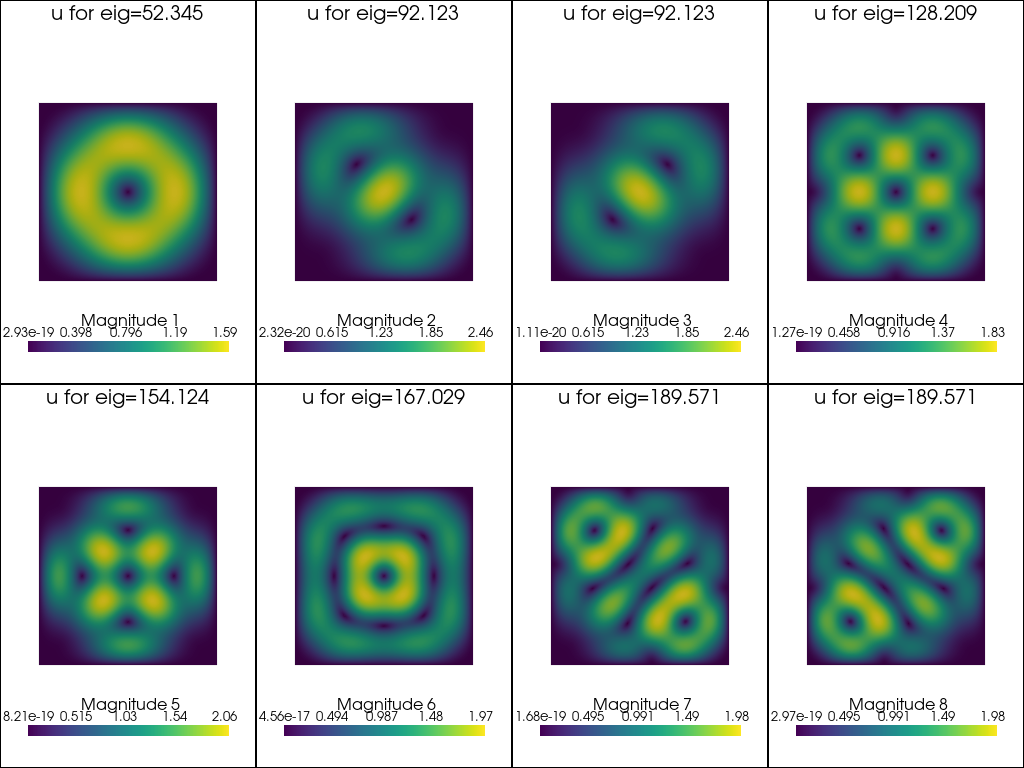

In [57]:
options = {"position_x": 0.11,
           "position_y": 0.08,
           "width": 0.8,
           "title_font_size": 16,
           "label_font_size": 13, 

}
multiple_plots_vectors(velocity_list, u.function_space, titles_u, options, bar=True)

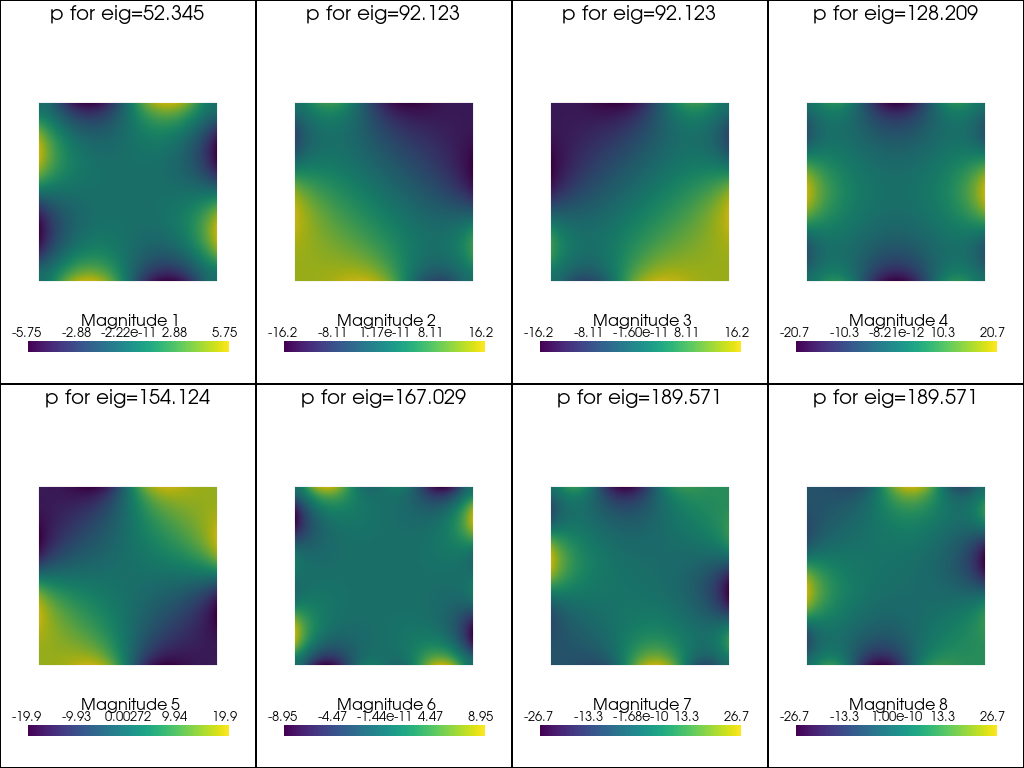

In [58]:
multiple_plots_scalar(pressure_list, p.function_space, titles_p, options, bar=True)